# SpectralFPM Simulation

Neerja Aggarwal

Oct 23rd, 2024

Simulate the measurement & attempt reconstruction for a spectral object. 


In [35]:
import fpm_helper as fpm
import matplotlib.pyplot as plt
import numpy as np
import torch
# plt.style.use('dark_background')

In [36]:
device = fpm.use_gpu(1)

cuda:1


# setup the fpm system

In [37]:
mag = 4 # 4x 
pix_size_camera = 4 #  micron"

wv_start = 400e-3 # micron
wv_end = 800e-3 # micron
wv_step = 100e-3 # micron
wv_range = np.arange(wv_start,wv_end, wv_step)
print(wv_range)

# wv = 500e-3 # micron
na_obj = 0.05 # low na objective 

fpm_setup = fpm.FPM_setup(mag = mag, pix_size_camera = pix_size_camera, wv = wv_range, na_obj = na_obj)
print(fpm_setup)

[0.4 0.5 0.6 0.7]
Using stock object data
FPM Setup Parameters:
--------------------
Camera pixel size: 4 microns
Magnification: 4x
Object pixel size: 1.000 microns
Numerical aperture: 0.05
Wavelength(s): [0.4 0.5 0.6 0.7] microns
Number of wavelengths: 4
Image dimensions: 1178 x 1178 pixels
LED Spacing: 5 mm
Distance: 75 mm
Total number of angles: 0
--------------------


# view the obj

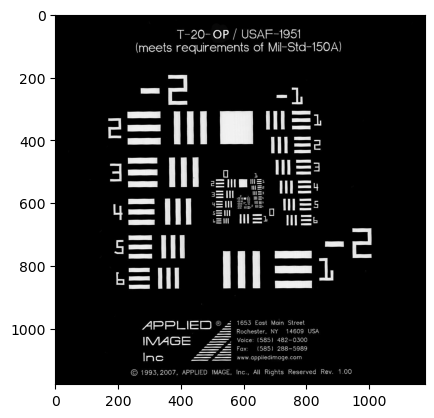

In [38]:
plt.imshow(torch.sum(fpm_setup.objstack, dim =0), cmap = 'gray')

# simulate some measurements

[((0.0, 0.0), (0,)), ((0.0, 0.0), (1,)), ((0.0, 0.0), (2,)), ((0.0, 0.0), (3,)), ((-0.017538068749853336, 0.02736674549466802), (0,)), ((-0.017538068749853336, 0.02736674549466802), (1,)), ((-0.017538068749853336, 0.02736674549466802), (2,)), ((-0.017538068749853336, 0.02736674549466802), (3,)), ((0.0087391062189576, -0.03412197499050144), (0,)), ((0.0087391062189576, -0.03412197499050144), (1,)), ((0.0087391062189576, -0.03412197499050144), (2,)), ((0.0087391062189576, -0.03412197499050144), (3,)), ((0.02807133244175382, -0.0245544586214932), (0,)), ((0.02807133244175382, -0.0245544586214932), (1,)), ((0.02807133244175382, -0.0245544586214932), (2,)), ((0.02807133244175382, -0.0245544586214932), (3,)), ((0.01425215614679847, 0.035948497185189686), (0,)), ((0.01425215614679847, 0.035948497185189686), (1,)), ((0.01425215614679847, 0.035948497185189686), (2,)), ((0.01425215614679847, 0.035948497185189686), (3,)), ((0.04108222265466329, 0.017951344671923226), (0,)), ((0.04108222265466329,

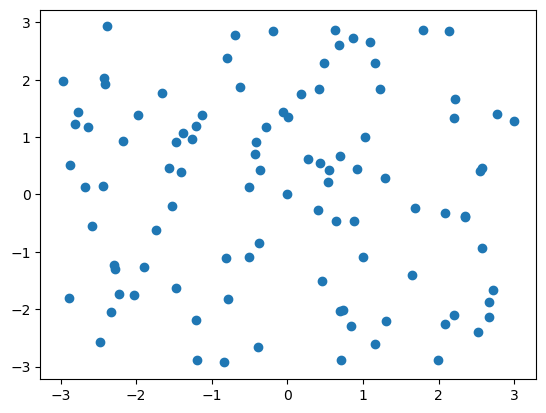

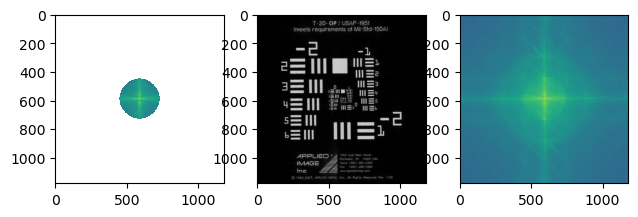

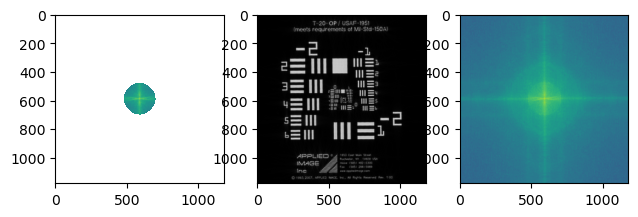

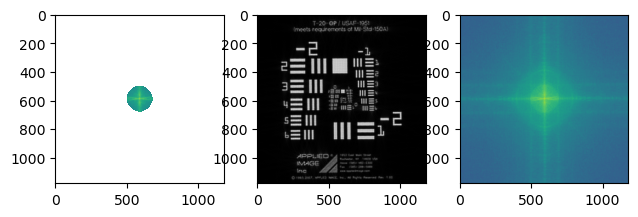

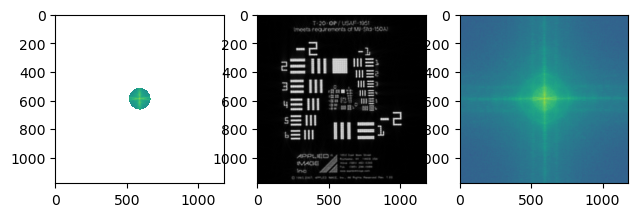

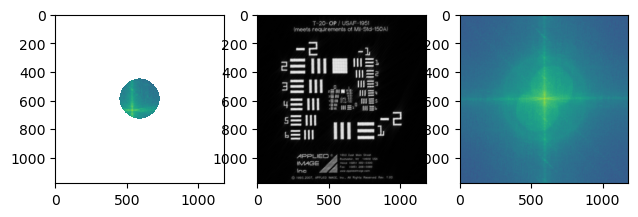

In [39]:
d = 75
led_spacing = 5
num_leds = 100
list_leds = fpm.createlist_led(num_leds,-3,3) 
# print(list_leds)
plt.scatter(list_leds[:,1],list_leds[:,0])
list_illums = fpm_setup.createMultiWavelengthPerAngleIllumList(list_leds)
print(list_illums)
measstack = fpm_setup.createMeasStackFromListIllums()

# Recon

In [40]:
recon = fpm.Reconstruction(fpm_setup, measstack, device = 2)
recon.initRecon()
recon.parameters(step_size=1e-3, num_iters=100)
print(recon)

cuda:2
Reconstruction Parameters:
--------------------
Number of measurements: 404
Device: cuda:2
Step size: 0.001
Iterations per measurement: 100
Number of epochs: 1
Optimizer type: Adam
Loss function: 2-norm
--------------------
FPM Setup Parameters:
--------------------
Camera pixel size: 4 microns
Magnification: 4x
Object pixel size: 1.000 microns
Numerical aperture: 0.05
Wavelength(s): [0.4 0.5 0.6 0.7] microns
Number of wavelengths: 4
Image dimensions: 1178 x 1178 pixels
LED Spacing: 5 mm
Distance: 75 mm
Total number of angles: 101
Number of illumination configurations: 404
Illumination strategy: Multi wavelength per angle
--------------------


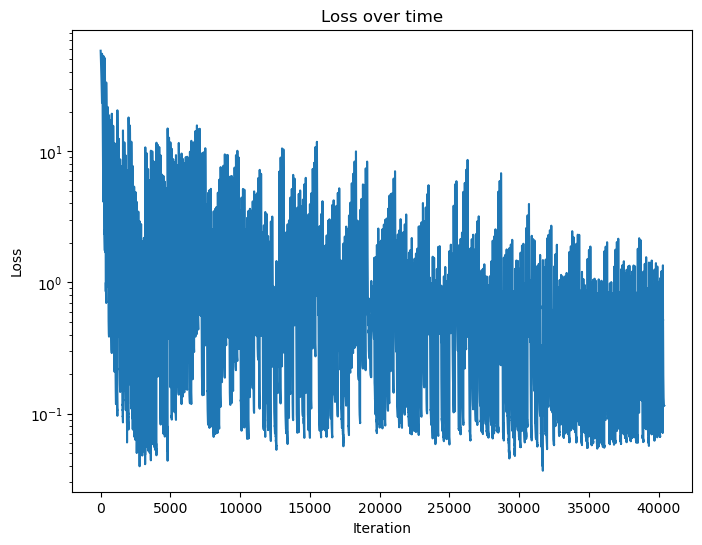

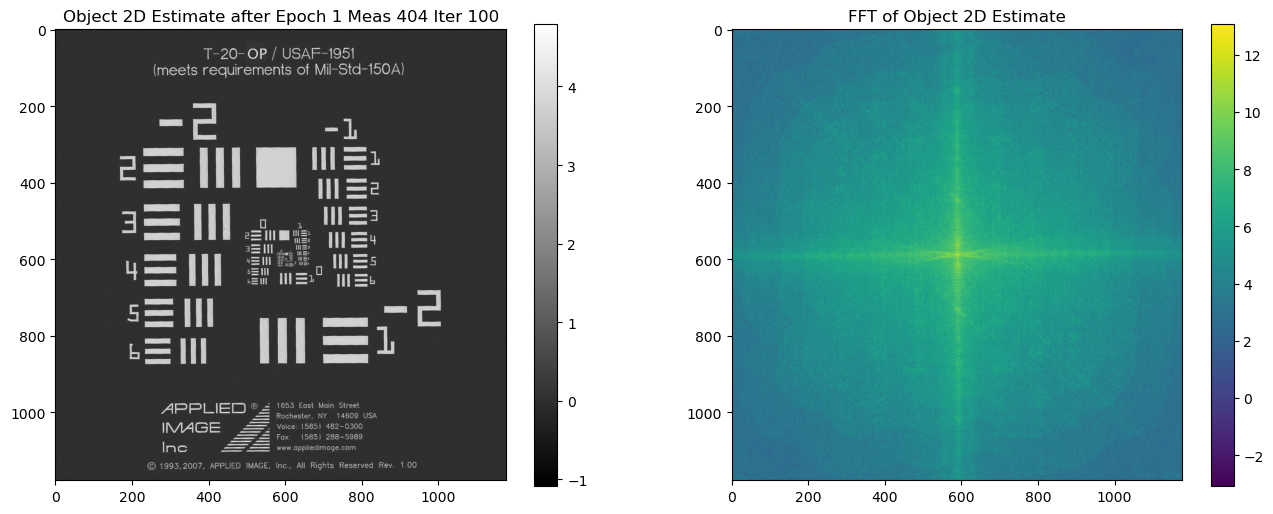

In [41]:
recon.train()

In [42]:
objest = recon.objest.detach().cpu().numpy()

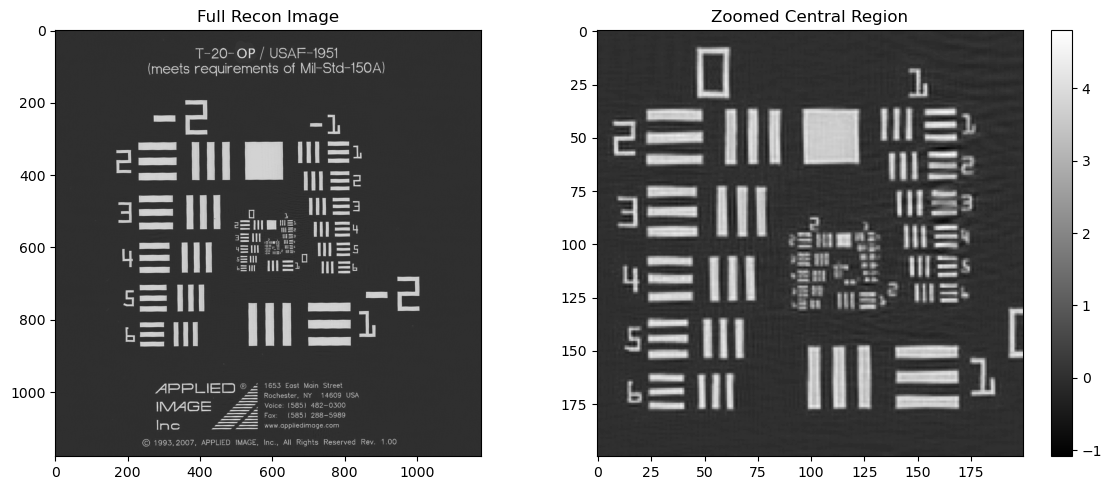

In [43]:
# zooom into the center smaller region
# Get the object estimate
obj2d = np.sum(objest, axis=0)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Full image
ax1.imshow(obj2d, cmap='gray')
ax1.set_title('Full Recon Image')

# Zoomed central region
center_y, center_x = obj2d.shape[0]//2, obj2d.shape[1]//2
zoom_size = 200  # Adjust this value to change zoom level
zoom_region = obj2d[center_y-zoom_size//2:center_y+zoom_size//2, 
                   center_x-zoom_size//2:center_x+zoom_size//2]
im2 = ax2.imshow(zoom_region, cmap='gray')
ax2.set_title('Zoomed Central Region')
fig.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

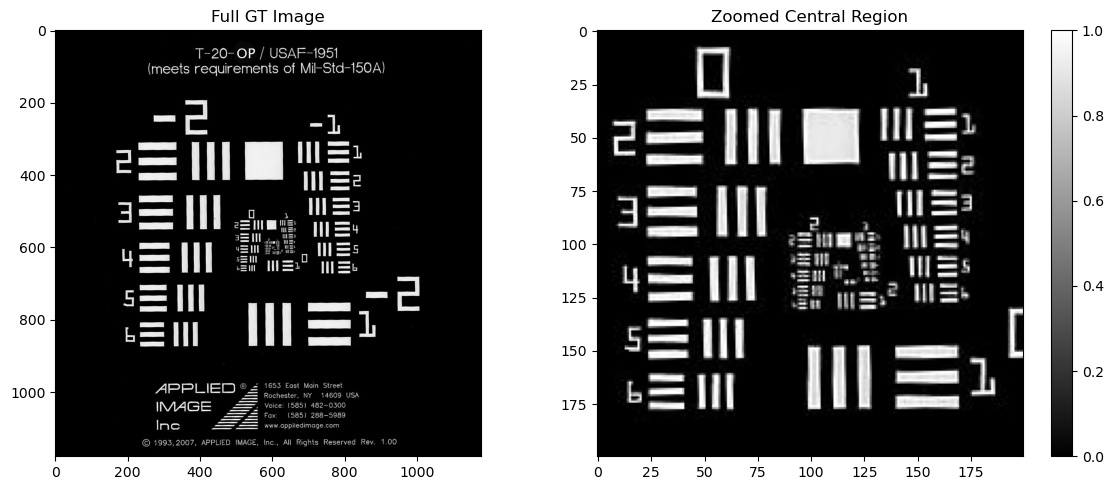

In [44]:
# look a the ground truth
plt.figure()
obj2d = np.squeeze(fpm_setup.obj.detach().cpu().numpy())

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Full image
ax1.imshow(obj2d, cmap='gray')
ax1.set_title('Full GT Image')

# Zoomed central region
center_y, center_x = obj2d.shape[0]//2, obj2d.shape[1]//2
zoom_size = 200  # Adjust this value to change zoom level
zoom_region = obj2d[center_y-zoom_size//2:center_y+zoom_size//2, 
                   center_x-zoom_size//2:center_x+zoom_size//2]
im2 = ax2.imshow(zoom_region, cmap='gray')
ax2.set_title('Zoomed Central Region')
fig.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()


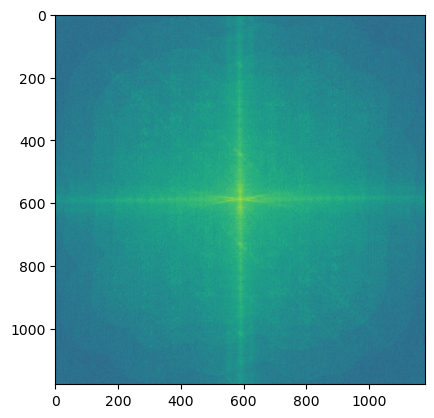

In [45]:
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(np.squeeze(np.sum(objest, axis = 0)))))))

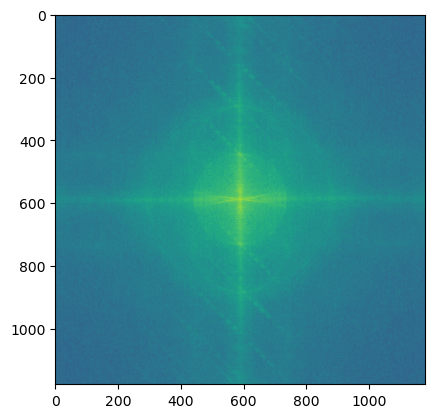

In [46]:
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(np.squeeze(recon.fpm_setup.measstack[0].cpu().numpy()))))))

## compare wavelength channels

Text(0.5, 1.0, '800 nm')

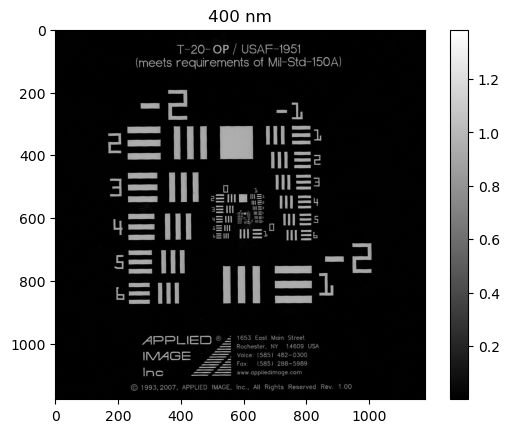

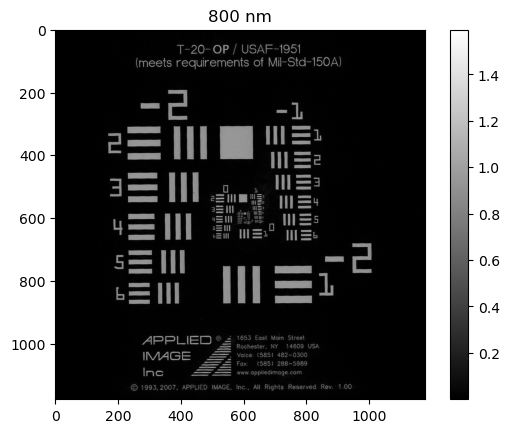

In [47]:
plt.imshow(np.abs(objest[0,:,:]), cmap = 'gray')
plt.colorbar()
plt.title('400 nm')
plt.figure()
plt.imshow(np.abs(objest[-1,:,:]), cmap = 'gray')
plt.colorbar()
plt.title('800 nm')
